In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# 전처리된 데이터 셋 불러오기

In [2]:
# 주피터노트북 단축키
# https://nittaku.tistory.com/428

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import datetime, time
import re
import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

## DataFrame 2가지 존재 ( 원본, 중복제거 )

- 중복제거 데이터가 성능이 뛰어남.

In [4]:
# 중복 제거 X
df_news = pd.read_csv('./Data_Set/news_data_preprocessing.csv', engine= 'python',encoding = 'utf-8')
# 중복 제거 O
df_news_overlap = pd.read_csv('./Data_Set/news_data_preprocessing_duplicate.csv', engine= 'python',encoding = 'utf-8')

In [5]:
len(df_news_overlap)

19303

In [6]:
df_news.columns

Index(['Unnamed: 0', 'date', 'year', 'month', 'day', 'title', 'nouns_title',
       'press', 'contents', 'nouns_contents'],
      dtype='object')

In [7]:
df_news = df_news.loc[:,['date', 'year', 'month', 'day', 'title', 'nouns_title',
       'press', 'contents', 'nouns_contents']]
df_news_overlap = df_news_overlap.loc[:,['date', 'year', 'month', 'day', 'title', 'nouns_title',
       'press', 'contents', 'nouns_contents']]

In [8]:
# 시각화 글자 깨짐 방지
if os.name == 'posix':
    plt.rc("font", family="Malgun Gothic")
else:
    plt.rc("font", family="Malgun Gothic")

# 레이블링 / 데이터 셋 분할 / 정수 인코딩

- 긍정 부정 단어를 분류 기초 방식. 따라서 보충이 필요.

**※논문 참고(계산법) : http://www.koreascience.kr/article/JAKO201719363360793.pdf**

## 레이블링

In [9]:
pos_word = []
neg_word = []
pos_neg = []

pos = open('./pos_neg_dictionary/positive_word.txt', 'r', encoding='UTF-8')

while True:
    line = pos.readline().rstrip()
    pos_word.append(line)
    
    if not line:
        break

pos.close()

neg = open('./pos_neg_dictionary/negative_word.txt', 'r', encoding='UTF-8')

while True:
    line = neg.readline().rstrip()
    neg_word.append(line)
    
    if not line:
        break

neg.close()

In [10]:
# 마지막 인덱스 '' 제거
pos_word = pos_word[:-1]
neg_word = neg_word[:-1]
pos_neg = pos_word + neg_word

### 2개의 클래스로 이진분류 --> 중립은 갯수만 파악

In [11]:
pd.set_option('mode.chained_assignment',  None) # 경고 off
state = list()

# 중립 갯수
mid = 0
for x in df_news_overlap['nouns_contents']:
    words = x.split(' ')
    total, p, n = 0, 0, 0
    for i in words:
        if i in pos_word:
            p += 1
        elif i in neg_word:
            n += 1
    
    # 기사 제목당 긍정갯수 - 부정 갯수
    total = p - n
    if total > 0:
        state.append(1)
    elif total == 0:
        state.append(0)
    else:
        state.append(-1)

print('부정:%d   긍정:%d   중립:%d' % (state.count(-1), state.count(1), mid))


df_news_overlap['label'] = 0
for i in range(len(state)):
    if state[i] != 0:
        df_news_overlap['label'][i] = state[i]

# df_news_overlap[df_news_overlap['label'].contains(0)].index
# 중립 제거
remove_mid_value = df_news_overlap[df_news_overlap['label'] == 0].index
df_news_overlap.drop(remove_mid_value, inplace = True)

부정:1432   긍정:13720   중립:0


In [12]:
# 중립 --> 학습 데이터에서 제거
mid

0

In [13]:
df_news_overlap['label'].head(3)

1    1
2    1
3    1
Name: label, dtype: int64

In [14]:
# 인덱스 번호 새로 부여
df_news_overlap.reset_index(inplace=True)
df_news_overlap.drop(['index'], axis=1, inplace=True)

## Train Set / Test Set 분할

- Train Set과 Test Set으로 분류 ( 7:3 )
- train_test_split() 함수에서 shuffle / default option : True.
- stratify 옵션 중요 !!
- Pos : 개선 / Neg : 불만

**참고 https://sosoeasy.tistory.com/488 / https://teddylee777.github.io/scikit-learn/train-test-split**

In [15]:
from sklearn.model_selection import train_test_split

### 데이터 분할 시 테이블 변경 가능

In [16]:
# 필요한 데이터만 추출 / 컬럼명 변경
# 80% / 20% 으로 분할
x_train, x_test = train_test_split(df_news_overlap.loc[:,['date', 'year', 'month', 'day','nouns_contents', 'label']], test_size = 0.3, shuffle = True, random_state = 42)

In [17]:
# 인덱스 번호 새로 부여.
x_train.reset_index(inplace=True)
x_train.drop(['index'], axis=1, inplace=True)

x_test.reset_index(inplace=True)
x_test.drop(['index'], axis=1, inplace=True)

In [18]:
# 2개의 데이터 프레임 생성
print(type(x_train), type(x_test))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


### Train Set / Test Set 시각화 및 레이블 현황

**참고 : isin() 문법 참고 : https://rfriend.tistory.com/460**

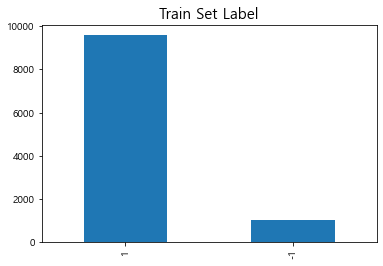

In [19]:
x_train['label'].value_counts().plot(kind='bar')
plt.title('Train Set Label', size = 15)
plt.show()

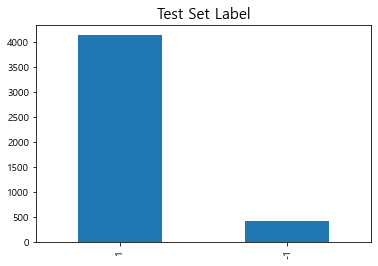

In [20]:
x_test['label'].value_counts().plot(kind='bar')
plt.title('Test Set Label', size = 15)
plt.show()

In [21]:
# Train_Set 레이블 현황 갯수
print('Train_Set  긍정(1) : {} \n\t   중립(0) : {} \n\t   부정(-1) : {} \n\t   총 합계 : {}'.format(len(x_train[x_train['label'].isin([1])]), len(x_train[x_train['label'].isin([0])]), len(x_train[x_train['label'].isin([-1])]), len(x_train)))
print()
# Test_Set 레이블 현황 갯수
print('Test_Set   긍정(1) : {} \n\t   중립(0) : {} \n\t   부정(-1) : {} \n\t   총 합계 : {}'.format(len(x_test[x_test['label'].isin([1])]), len(x_test[x_test['label'].isin([0])]), len(x_test[x_test['label'].isin([-1])]), len(x_test)))

Train_Set  긍정(1) : 9591 
	   중립(0) : 0 
	   부정(-1) : 1015 
	   총 합계 : 10606

Test_Set   긍정(1) : 4129 
	   중립(0) : 0 
	   부정(-1) : 417 
	   총 합계 : 4546


## Convert to two_dimensional list

In [22]:
print(len(x_train), len(x_test))

10606 4546


In [23]:
x_train.head(20)

,date,year,month,day,nouns_contents,label
0,2019-10-08,2019,10,8,대 구 은행 2016년 라오스 DGB 캐피탈 자회사 DGB Lao Leasing C...,-1
1,2021-01-26,2021,1,26,DGB 대 구 은행 지역 아동 학습 환경 개선 을 위해 진행 하고 있다 DGB 행복...,1
2,2021-07-15,2021,7,15,▲ DGB 대구 은행 본점 에서 진행 되다 정보보호 실천 캠페인 에서 임성훈 대 구...,1
3,2019-08-01,2019,8,1,그룹 주력 계열 사인 DGB 대 구 은행 영업 이익 당기다 순이익 시장 금리 하락 ...,-1
4,2020-03-11,2020,3,11,DGB 대구 은행 김태오 행 장 왼쪽 11일 본점 에서 신종 코로나바이러스 감염증 ...,1
5,2021-06-29,2021,6,29,저축은행 중앙회 2016년 우리은행 연 계 대출 협약 을 맺다 것 을 시작 2017...,1
6,2021-02-26,2021,2,26,이다 DGB 대 구 은행 전 년 대비 156% 줄어들다 2383억원 순이익 을 기록...,-1
7,2019-07-02,2019,7,2,김태오 DGB 대 구 은행 장 바이오 헬스 분야 창업 기업 적극 협조 DGB 대 구...,1
8,2020-10-08,2020,10,8,DGB 대 구 은행 캄보디아 현지 법인 DGB 특수은행 DGB Specialized...,-1
9,2022-03-02,2022,3,2,최병수 기자 DGB 대구 은행 139130 2일 도청 신도시 지점 지점 장 김경 봉...,1


In [24]:
x_test.head(3)

,date,year,month,day,nouns_contents,label
0,2019-06-18,2019,6,18,조인호 기자 DGB 대 구 은행 은행 장 김태오 18일 담양 달빛 무월 마을 에서 ...,1
1,2021-02-25,2021,2,25,DGB 대 구 은행 캄보디아 현 법인 DGB 특수은행 본사 부지 매입 과정 에서 1...,-1
2,2021-01-18,2021,1,18,DGB 대 구 은행 설 연휴 앞두다 5000억원 규모 설날 특별 자금 대출 을 다음...,1


In [25]:
# 리스트로 변환 후 체크 
# 6263
x_train_words = list()
for title_words in x_train['nouns_contents']:
    x_train_words.append(list(title_words.split(' ')))

# 2685
x_test_words = list()
for title_words in x_test['nouns_contents']:
    x_test_words.append(list(title_words.split(' ')))

In [26]:
print(x_train_words[:2])

[['대', '구', '은행', '2016년', '라오스', 'DGB', '캐피탈', '자회사', 'DGB', 'Lao', 'Leasing', 'Company', 'Co', 'LtdDLCC', '현', '법인', '을', '설립', '이다', '지난해', '1월', '캄보디아', 'MFI', '여', '신', '전', '문', '금융기관', '캠', '캐피탈', '은행', '을', '100%', '분', '인수', 'DGB', '특수은행', 'DGB', 'Specialized'], ['DGB', '대', '구', '은행', '지역', '아동', '학습', '환경', '개선', '을', '위해', '진행', '하고', '있다', 'DGB', '행복', '꽃', '피다', '공', '부방', '사업', '진행', '따르다', '공로', '인정받다', '경북', '사', '회복', '협의', '회로', '부터', '감사패', '전달', '받다', 'DGB', '행복', '꽃', '피다', '공', '부방', '만들기']]


In [27]:
print(x_test_words[:2])

[['조인호', '기자', 'DGB', '대', '구', '은행', '은행', '장', '김태오', '18일', '담양', '달빛', '무월', '마을', '에서', '광주', '은행', '은행', '장', '송종욱', '함께', '영', '호남', '지역', '간', '민간', '교류', '통한', '화합', '소통', '시간', '을', '위해', '2019', '달빛', '동맹', '강화', '봉사활동', '을', '실시', '날'], ['DGB', '대', '구', '은행', '캄보디아', '현', '법인', 'DGB', '특수은행', '본사', '부지', '매입', '과정', '에서', '1200', '여', '달러', '사기', '당한', '것', '뒤늦다', '알려지다', '25일', 'DGB', '대', '구', '은행', '따르다', '해외', '자회사', '캄보디아', 'DGB', '특수은행']]


## Integer Encoding
- 토큰화 한 단어를 컴퓨터가 인식하도록 정수 인코딩 수행

In [28]:
from keras.preprocessing.text import Tokenizer

In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train_words)
tokenizer.fit_on_texts(x_test_words)

In [30]:
x_train_int = tokenizer.texts_to_sequences(x_train_words)

In [31]:
x_test_int = tokenizer.texts_to_sequences(x_test_words)

In [32]:
print(x_train_int[:3])

[[4, 5, 1, 1565, 1667, 2, 141, 523, 2, 8550, 8551, 6123, 8552, 8553, 473, 293, 3, 660, 37, 104, 903, 182, 1848, 322, 172, 36, 278, 819, 3657, 141, 1, 3, 1618, 740, 1067, 2, 688, 2, 3379], [2, 4, 5, 1, 9, 346, 1321, 206, 208, 3, 17, 38, 21, 14, 2, 202, 729, 801, 140, 1171, 83, 38, 44, 1566, 1493, 30, 128, 231, 577, 3380, 45, 1494, 48, 99, 2, 202, 729, 801, 140, 1171, 1722], [114, 2, 6, 1, 27, 8, 38, 16, 682, 229, 234, 8, 42, 4, 5, 1, 11, 886, 608, 682, 397, 3035, 2853, 2319, 541, 886, 3658, 1390, 20, 60, 92, 384, 3, 14, 34, 5551]]


In [33]:
print(x_test_int[:3])

[[1633, 86, 2, 4, 5, 1, 1, 11, 49, 285, 3136, 1763, 2709, 1037, 8, 264, 1, 1, 11, 2863, 62, 215, 3619, 9, 238, 1196, 1427, 124, 2845, 536, 796, 3, 17, 480, 1763, 2506, 197, 383, 3, 35, 106], [2, 4, 5, 1, 182, 473, 293, 2, 688, 879, 1831, 554, 724, 8, 2824, 322, 1147, 844, 5191, 134, 4749, 1669, 363, 2, 4, 5, 1, 44, 670, 523, 182, 2, 688], [2, 4, 5, 1, 505, 1764, 327, 666, 148, 611, 131, 88, 19, 3, 339, 119, 367, 64, 18, 285, 10, 19, 73, 591, 40, 614, 3, 188, 14, 101, 355, 153, 52, 226, 157, 746, 1242]]


## 제목 길이 기준 분포 확인

In [34]:
# print('최대 길이(단어의 수) :', max([(len(i)) for i in x_train_int]))
# print('평균 길이 :', sum([len(i) for i in x_train_int]) // len(x_train_int))
# plt.figure(figsize = (12, 8))
# plt.hist([len(i) for i in x_train_int], bins=90)
# plt.xlabel('length fo Data')
# plt.ylabel('number fo Data')
# plt.show()

In [35]:
# print('최대 길이(단어의 수) :', max([(len(i)) for i in x_test_int]))
# print('평균 길이 :', sum([len(i) for i in x_test_int]) // len(x_test_int))
# plt.figure(figsize = (12, 8))
# plt.hist([len(i) for i in x_test_int], bins=90)
# plt.xlabel('length fo Data')
# plt.ylabel('number fo Data')
# plt.show()

## Padding

- 길이를 길게 잡으면 학습 시간이 오래 걸림 --> 데이터 손실 최소화 + 효율성
- 데이터가 비교적 적은 부분은 패딩으로 처리하는게 좋음.
- maxlen의 인자로 정수를 주면, 해당 정수로 모든 문서의 길이를 동일

**Ex) 길이가 5인 리스트가 있다면 5보다 작은 인덱스 값들은 0으로 패딩되고 5보다 큰 인덱스들은 즉, 6번째 인덱스부터는 데이터가 손실됨.**<br><br>
**참고<br> https://wikidocs.net/83544 (2/5 지점)<br>http://www.nextobe.com/2020/05/14/%EA%B0%80%EB%B3%80-%EA%B8%B8%EC%9D%B4-%EC%9E%85%EB%A0%A5-%EC%8B%9C%ED%80%80%EC%8A%A4%EC%97%90-%EB%8C%80%ED%95%9C-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%A4%80%EB%B9%84/<br>https://sig413.tistory.com/5**

In [36]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [37]:
# 각 인덱스 길이대로 정렬
x_train_int.sort(key=lambda x:len(x),reverse = True)
x_test_int.sort(key=lambda x:len(x),reverse = True)

In [38]:
def limit_len(front, back, reset_list):
    cnt = 0
    for s in reset_list:
        # if (front <= len(s) <= back):
        if len(s) <= back:
            cnt += 1
    print('전체 학습 데이터 중 길이가 {} 이상 {} 이하인 비율 : {:.2f}%'.format(front, back,( cnt / len(x_train_int)) * 100))

In [39]:
# min_len = 4 / max_len = 14
# 앞선 제목의 평균 길이 그래프를 보면 ( 4 <= idx_num <= 14 ) 범위를 벗어난 인덱스들은 데이터가 현저히 적음.
limit_len(0, 60, x_train_int)

전체 학습 데이터 중 길이가 0 이상 60 이하인 비율 : 99.91%


**일단 14이하인 것만 패딩 --> 나중에 시간되면 4이상 14이하인 부분만 패딩하도록 전처리 필요**
<br>
**pad_sequences post / defalut로 각각 한번씩 해주면 됨.**

In [40]:
max_len = 60

In [41]:
# x_train_final --> x_train

In [42]:
X_train = pad_sequences(x_train_int, maxlen = max_len)

In [43]:
X_test = pad_sequences(x_test_int, maxlen = max_len)

## One-Hot-Encoding

- 단어 집합의 크기를 벡터로 변환하고, 표현하고 싶은 단어 인덱스에 1의 값 부여하고, 다른 인덱스는 0을 부여하는 단어의 벡터 표현 방식
- 즉, 1개만 Hot(True)이고 나머지는 Cold(False)

※ 벡터 (1차원)  /  행렬 (2차원)  /  배열 (3차원)  /  텐서 (3차원 이상)
<br>
<br>
**참고 : https://godcode.tistory.com/9?category=908926**

In [44]:
tokenizer.word_index

{'은행': 1,
 'dgb': 2,
 '을': 3,
 '대': 4,
 '구': 5,
 '대구': 6,
 '금융': 7,
 '에서': 8,
 '지역': 9,
 '밝히다': 10,
 '장': 11,
 '등': 12,
 '로': 13,
 '있다': 14,
 '\xa0': 15,
 '되다': 16,
 '위해': 17,
 '지원': 18,
 '대출': 19,
 '및': 20,
 '하고': 21,
 '그룹': 22,
 '제공': 23,
 '서비스': 24,
 '제': 25,
 '코로나': 26,
 '본점': 27,
 '고객': 28,
 '19': 29,
 '경북': 30,
 '기업': 31,
 '위': 32,
 '협약': 33,
 '지난': 34,
 '실시': 35,
 '전': 36,
 '이다': 37,
 '진행': 38,
 '사진': 39,
 '적': 40,
 '업무': 41,
 '임성훈': 42,
 '이번': 43,
 '따르다': 44,
 '부터': 45,
 '상품': 46,
 '2': 47,
 '전달': 48,
 '김태오': 49,
 'im': 50,
 '수': 51,
 '원': 52,
 '행사': 53,
 '회장': 54,
 '기': 55,
 '투자': 56,
 '영업': 57,
 '금리': 58,
 '적금': 59,
 '직원': 60,
 '디지털': 61,
 '함께': 62,
 '사랑': 63,
 '까지': 64,
 '증권': 65,
 '뱅크': 66,
 '사회': 67,
 '통해': 68,
 '지주': 69,
 '비대': 70,
 '출시': 71,
 '식': 72,
 '대상': 73,
 '센터': 74,
 '카드': 75,
 '활성화': 76,
 '오다': 77,
 '계열': 78,
 '순이익': 79,
 '체결': 80,
 '하이': 81,
 '1': 82,
 '사업': 83,
 '이벤트': 84,
 '모바일': 85,
 '기자': 86,
 '개': 87,
 '자금': 88,
 '돼다': 89,
 '신용': 90,
 '앱': 91,
 '기념': 92,
 '

In [45]:
len(tokenizer.word_index)

12862

## get dummies --> 원핫인코딩

In [46]:
# pd.get_dummies()로 쉽게 원핫인코딩 가능.

y_train = pd.get_dummies(x_train['label']).to_numpy()
y_test = pd.get_dummies(x_test['label']).to_numpy()

In [47]:
# y_train = list()
# y_test = list()
# X_train['label'].unique().tolist()

In [48]:
# # 1 / 0 / -1
# def one_hot_encoding(label):
#     one_hot_vector = [0] * len(X_train['label'].unique().tolist())
#     one_hot_vector[label+1] = 1
#     return one_hot_vector

# def right_answer():
#     for tr in X_train['label']:
#         y_train.append(one_hot_encoding(tr))
#     for te in X_test['label']:
#         y_test.append(one_hot_encoding(te))

# right_answer()

In [49]:
# if (len(y_train) + len(y_test)) == len(df_news_overlap['label']):
#     print('정상')
# else:
#     y_train = list()
#     y_test = list()
#     right_answer()
#     print('재확인 필요')

# y_train = np.array(y_train)
# y_test = np.array(y_test)

## 빈도 수가 낮은 단어 제거 --> 대기
- 빈도수가 낮은 단어 --> 학습에 영향이 크지 않음.
- 전처리를 통해 제거
- 패딩 --> 학습 시간 단축 및 최적의 효율성

**한두번 나온 단어가 그 문장의 감성을 표현할 수 있는 핵심단어 일수도?**

In [50]:
len(tokenizer.word_counts)

12862

In [51]:
threshold = 2 # 임계치
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    words_freq += value
    if value < threshold:
        rare_cnt += 1
        rare_freq += value
print('단어 집합(vocabulary)의 종류 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' % (threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율: {:.2f}".format((rare_cnt / total_cnt) * 100))
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / words_freq) * 100)

단어 집합(vocabulary)의 종류 : 12862
등장 빈도가 1번 이하인 희귀 단어의 수: 4313
단어 집합에서 희귀 단어의 비율: 33.53
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7118547836047283


In [52]:
vocab_size = total_cnt-rare_cnt
print(vocab_size)

8549


In [53]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')

In [54]:
tokenizer

In [55]:
x_train.head(3)

,date,year,month,day,nouns_contents,label
0,2019-10-08,2019,10,8,대 구 은행 2016년 라오스 DGB 캐피탈 자회사 DGB Lao Leasing C...,-1
1,2021-01-26,2021,1,26,DGB 대 구 은행 지역 아동 학습 환경 개선 을 위해 진행 하고 있다 DGB 행복...,1
2,2021-07-15,2021,7,15,▲ DGB 대구 은행 본점 에서 진행 되다 정보보호 실천 캠페인 에서 임성훈 대 구...,1


In [56]:
x_test.head(3)

,date,year,month,day,nouns_contents,label
0,2019-06-18,2019,6,18,조인호 기자 DGB 대 구 은행 은행 장 김태오 18일 담양 달빛 무월 마을 에서 ...,1
1,2021-02-25,2021,2,25,DGB 대 구 은행 캄보디아 현 법인 DGB 특수은행 본사 부지 매입 과정 에서 1...,-1
2,2021-01-18,2021,1,18,DGB 대 구 은행 설 연휴 앞두다 5000억원 규모 설날 특별 자금 대출 을 다음...,1


In [57]:
x_train.to_csv('./Data_Set/X_train.csv')
x_test.to_csv('./Data_Set/X_test.csv')

# 모델링

- 성능 높이기 + 시각화 해서 파일로 만들기

**https://sieon-dev.tistory.com/15**

## GPU 체크
- NVIDIA GeForce RTX 2070 SUPER : 2개 (GPU index number : 0, 1)
- CPU :1 개 ( CPU index number : 0)

In [58]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


In [59]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [60]:
%matplotlib inline
# Function call stack:
# train_function -> train_function -> train_function
# 해당 줄로 오류 해결
# 참고 : https://www.freesion.com/article/71721347190/
tf.compat.v1.disable_eager_execution()

## 데이터셋 확인

In [61]:
from keras import models
from tensorflow.python.client import device_lib
from tensorflow.keras.layers import BatchNormalization, Embedding, Dense, GRU, Dropout, Input, LSTM, Activation, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, SpatialDropout1D, TimeDistributed, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model

In [62]:
print('X_train :', X_train.shape)
print('X_test :', X_test.shape)
print('y_train :', y_train.shape)
print('X_test :', y_test.shape)

X_train : (10606, 60)
X_test : (4546, 60)
y_train : (10606, 2)
X_test : (4546, 2)


## 옵티마이저 튜닝

- optimizers 정의 및 튜닝 ( Adam, SGD, RMSprop)
- 하이퍼 파라미터 튜닝

**val_loss 감소시키는 방법 : https://lsjsj92.tistory.com/353**

In [63]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, decay=0.0001, clipnorm=1., epsilon=None, amsgrad=False)

sgd = SGD(learning_rate=0.01, momentum=0.9, decay=0.0001, nesterov=False)

rmsprop = RMSprop(learning_rate=0.001, rho=0.9, decay=0.0001, epsilon=None)

## 모델 구축 및 데이터 학습

- val_accuracy도 점점 떨어지고 있는 것으로 봐서 네트워크가 과적합되는 것으로 보입니다. 과적합의 이유는 임베딩 레이어를 랜덤한 값에서부터 시작해서 학습시키기 때문에 각 단어를 나타내는 벡터의 품질

**모델 샘플 : https://www.kaggle.com/code/nafisur/keras-models-lstm-cnn-gru-bidirectional-glove/notebook**
<br><br>
**성능 개선 : https://wikidocs.net/142041**
<br><br>
**loss 함수 설명 : https://velog.io/@rcchun/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EC%86%90%EC%8B%A4%ED%95%A8%EC%88%98%EC%9D%98-%EC%A2%85%EB%A5%98#msemean-squared-error**
<br><br>
**LSTM / RNN / GRU 개념 : https://velog.io/@dong970827/RNN-LSTM-GRU-%EA%B0%9C%EB%85%90**

- 과적합 뜨는 이유
- 1. 긍정 80% / 부정 5% / 중립 15% (총 331개 Test Data) 데이터 갯수와 비율 때문이라고 판단.
- 2. 학습진행시 전체데이터에서 부정갯수가 가장 작은 편이므로, 긍정데이터에 대해서는 과적합

### LSTM ( 73 ~ 77% / 요약본 / 오차 작음)

In [64]:
# 하이퍼파라미터 : rmsprop / binary_crossentropy / 50 / 256 / 0.2
model_01 = Sequential()

model_01 = Sequential() # tensorflow.keras.models
model_01.add(Embedding(total_cnt, 100, input_length=max_len))
model_01.add(LSTM(128))
model_01.add(Dense(2, activation='sigmoid'))
model_01.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 100)           1286200   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
Total params: 1,403,706
Trainable params: 1,403,706
Non-trainable params: 0
_________________________________________________________________


### LSTM 2 Layer + Dropout (64 ~ 66 % / 요약본 / 오차 큼)

In [65]:
# 하이퍼파라미터 : adam / categorical_crossentropy / 50 / 512 / 0.2
model_02 = Sequential()

model_02.add(Embedding(total_cnt,100, mask_zero=True))
model_02.add(LSTM(64,dropout=0.7, recurrent_dropout=0.7,return_sequences=True))
model_02.add(LSTM(32,dropout=0.6, recurrent_dropout=0.6,return_sequences=False))
model_02.add(Dense(2, activation='sigmoid'))
model_02.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1286200   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          42240     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 1,340,922
Trainable params: 1,340,922
Non-trainable params: 0
_________________________________________________________________


### CNN + Dropout + LSTM ( 77 ~ 79 % / 요약본 / 오차 큼)

In [66]:
# 하이퍼파라미터 : adam / categorical_crossentropy / 100 / 128 / 0.2
model_03= Sequential()

model_03.add(Embedding(total_cnt, 100, input_length=max_len))
model_03.add(Conv1D(128, kernel_size=3, padding='same', activation='relu', strides=1))
model_03.add(Bidirectional(LSTM(64, dropout= 0.6, recurrent_dropout=0.6, return_sequences=True)))
model_03.add(GlobalMaxPooling1D())
model_03.add(BatchNormalization())

# model_03.add(Dropout(0.8))
# model_03.add(Dense(256, activation='relu'))
# model_03.add(Conv1D(128, kernel_size=3, padding='same', activation='relu', strides=1))
# model_03.add(Bidirectional(LSTM(128, dropout= 0.6, recurrent_dropout=0.6, return_sequences=True)))
# model_03.add(GlobalMaxPooling1D())
# model_03.add(BatchNormalization())
# model_03.add(Dropout(0.8))

model_03.add(Dense(64, activation='relu'))
model_03.add(Dense(2, activation='sigmoid'))
model_03.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 60, 100)           1286200   
_________________________________________________________________
conv1d (Conv1D)              (None, 60, 128)           38528     
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 128)           98816     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
________________________________________________

### Bi GRU + Dropout ( 75 ~ 77% / 요약본 / 오차 매우 작음)

In [67]:
model_04 = Sequential()

model_04.add(Embedding(total_cnt, 100, input_length=max_len))
model_04.add(SpatialDropout1D(0.25))
model_04.add(Bidirectional(GRU(128)))
model_04.add(Dropout(0.5))

model_04.add(Dense(2, activation='sigmoid'))
model_04.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 60, 100)           1286200   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 60, 100)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               176640    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 514       
Total params: 1,463,354
Trainable params: 1,463,354
Non-trainable params: 0
_________________________________________________________________


### Bi LSTM (  )

In [68]:
model_05 = Sequential()

model_05.add(Embedding(total_cnt, 100, input_length=max_len))
model_05.add(Bidirectional(LSTM(128, dropout= 0.5, recurrent_dropout=0.5, return_sequences=True)))

# model_05.add(Bidirectional(LSTM(128, dropout= 0.7, recurrent_dropout=0.7)))
model_05.add(GRU(64))
model_05.add(Dense(64, activation='relu'))
model_05.add(Dropout(0.2))
model_05.add(Dense(2, activation='sigmoid'))
model_05.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 60, 100)           1286200   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 60, 256)           234496    
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                61824     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 130       
Total params: 1,586,810
Trainable params: 1,586,810
Non-trainable params: 0
____________________________________________

In [69]:
def learning(model):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
    mc = ModelCheckpoint('bilstm.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

    # categorical_crossentropy / binary_crossentropy / mse / sparse_categorical_crossentropy
    # softmax / sigmoid
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])# 0.002 학습률
    history = model.fit(X_train, y_train, epochs=30, callbacks=[es, mc], batch_size=1024, validation_split=0.3)
    return history

## 모델 성능 평가 및 저장

- 과적합 : https://stackoverflow.com/questions/50615396/validation-loss-increasing
- https://stackoverflow.com/questions/61342448/train-accuracy-increases-train-loss-is-stable-validation-loss-increases-valid

In [ ]:
model_num = model_05
history = learning(model_num)

In [ ]:
print('예측률 : {:.2f}%'.format(model_num.evaluate(X_test, y_test)[1] * 100))

In [ ]:
# 모델 저장
model_num.save('./Model_Evaluation/Multiclass_model_01.h5')

In [ ]:
# from keras.models import load_model
# loaded_model = load_model('./HyperParameter_ModelLayer/LSTM_Sigmoid.h5')
# print("\n 테스트 정확도 : {:.2f}%%".format(loaded_model.evaluate(X_test, y_test)[1] * 100))

## 데이터 학습 시각화

- 오버피팅 : https://untitledtblog.tistory.com/158

In [ ]:
hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['accuracy']
val_acc = hist_dict['val_accuracy']
                
plt.plot(loss, 'b--', label = 'training loss')
plt.plot(val_loss, 'r:', label = 'validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc, 'b--', label='training accuracy')
plt.plot(val_acc, 'r:', label='validation accuracy')
plt.legend()
plt.grid()

In [ ]:
predict = model_num.predict(X_test)

In [ ]:
predict_labels = np.argmax(predict, axis = 1)
original_labels = np.argmax(y_test, axis = 1)

# 그래프 시각화
<br>

**언론사별 / 월별 / 주중별기사 수량 확인**
**아직 제대로 진행 안됨...**

## 저장된 모델 불러오기 ( 이진 분류 )

In [71]:
from keras.models import load_model

model_num = load_model('./Model_Evaluation/Binary_model_04_(82.37%)우수.h5')
print('예측률 : {:.2f}%'.format(model_num.evaluate(X_test, y_test)[1] * 100))

C:\Users\DGBDS\AppData\Roaming\Python\Python36\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


예측률 : 82.97%


In [72]:
predict = model_num.predict(X_test)
predict_labels = np.argmax(predict, axis = 1)
original_labels = np.argmax(y_test, axis = 1)

## 모델이 예측한 긍정 / 부정 / 중립 시각화

- X_test 데이터에 대한 y_test 데이터로 평가한 결과 시각화
- 시각화 전용 : df_df_Visualization 생성

In [73]:
y_train = pd.get_dummies(x_train['label']).to_numpy()
y_test = pd.get_dummies(x_test['label']).to_numpy()

In [74]:
def change_idx(labels):
    value_tmp = list()
    for i in labels:
        if i == 0:
            value_tmp.append('부정')
        if i == 1:
            value_tmp.append('긍정')
    # idx_tmp = list(set(value_tmp))
    return value_tmp # , idx_tmp

In [75]:
r_value_tmp = change_idx(original_labels)

ori_view = pd.Series(data = r_value_tmp)
ori_view.sort_index(ascending=True, inplace=True)

x = list(ori_view.keys())
y = ori_view.values

In [76]:
p_value_tmp= change_idx(predict_labels)

pre_view = pd.Series(data = p_value_tmp)
pre_view.sort_index(ascending=True, inplace=True)

w = list(pre_view.keys())
z = pre_view.values

In [77]:
df_Visualization = pd.DataFrame({'raw_label' : [0],
              'predict_label' : [0]}, index = range(len(predict_labels)))

In [78]:
x_test.head(3)

,date,year,month,day,nouns_contents,label
0,2019-06-18,2019,6,18,조인호 기자 DGB 대 구 은행 은행 장 김태오 18일 담양 달빛 무월 마을 에서 ...,1
1,2021-02-25,2021,2,25,DGB 대 구 은행 캄보디아 현 법인 DGB 특수은행 본사 부지 매입 과정 에서 1...,-1
2,2021-01-18,2021,1,18,DGB 대 구 은행 설 연휴 앞두다 5000억원 규모 설날 특별 자금 대출 을 다음...,1


In [79]:
df_Visualization.insert(0, 'date', x_test['date'], True)
df_Visualization.insert(1, 'year', x_test['year'], True)
df_Visualization.insert(2, 'month', x_test['month'], True)
df_Visualization.insert(3, 'day', x_test['day'], True)
df_Visualization.insert(4, 'nouns_contents', x_test['nouns_contents'], True)

In [80]:
idx = 0
for i, j in zip(df_Visualization['raw_label'].index, df_Visualization['predict_label'].index):
    # print(p_value_tmp[p_idx_tmp.index(i)])
    df_Visualization['raw_label'][i] = r_value_tmp[i]
    df_Visualization['predict_label'][j] = p_value_tmp[i]

In [83]:
df_Visualization.head(50)

,date,year,month,day,nouns_contents,raw_label,predict_label
0,2019-05-01,2019,5,1,DGB 대 구 은행 30일 대전 지점 대전광역시 서구 문예로 65 을 개점 하고 국...,긍정,부정
1,2019-05-01,2019,5,1,DGB 대 구 은행 엊그제 둔산동 대전 지역 1 호 점포 개설 하고 충청권 영업 본...,긍정,긍정
2,2019-05-02,2019,5,2,2일 DGB 금융 그룹 따르다 대구 은행 올해 1분 기 영업 이익 1150억원 당 ...,부정,긍정
3,2019-05-02,2019,5,2,경기 악화 대한 전망 확산 되다 대외 경제 역시 불확실 성 지속 되다 있다 수익 성...,긍정,긍정
4,2019-05-02,2019,5,2,DGB 금융 그룹 올해 1분 기 그룹 연결 기준 순이익 전 년 동기 대비 131% ...,긍정,긍정
5,2019-05-02,2019,5,2,DGB 금융 그룹 2019년 1분 기 하이 투자 증권 그룹 편입 비 은행 자회사 실...,긍정,긍정
6,2019-05-02,2019,5,2,DGB 금융 지난해 10월 하이 투자 증권 을 자회사 로 편입 바 있다 주력 계열 ...,부정,긍정
7,2019-05-02,2019,5,2,주력 계열 사인 대 구 은행 영업 이익 1150억원 전 년 대비 77% 줄다 순이익...,긍정,긍정
8,2019-05-02,2019,5,2,DGB 금융 그룹 2019년 1분 기 그룹 연결 기준 순이익 전 년 동기 대비 13...,긍정,긍정
9,2019-05-02,2019,5,2,DGB 금융 그룹 2일 올해 1분 기 1천 38억원 당 기 순이익 을 거두다 밝히다...,긍정,긍정


In [84]:
df_Visualization.sort_values('date', inplace = True)
df_Visualization.reset_index(inplace=True)
df_Visualization.drop(['index'], axis=1, inplace=True)

### [꺽은선 그래프] 월별 기사에 대한 예측 시각화 (테스트데이터 / 전체)

- raw_data만 생성 /predict_data도 시각화
- 추가적인 데이터가 들어올시 데이터 통합을 한 후 예측하면 됨.

In [85]:
from collections import defaultdict

def func(x):
    print(x.groupby('month')['raw_label'].count().tolist()[0],  end=' ')
    return
df_Visualization.groupby(['year', 'month']).apply(func)

133 82 124 122 89 131 117 82 104 175 156 72 127 128 119 138 87 123 82 165 140 115 131 161 127 137 189 160 144 161 94 158 95 113 110 154 1 

""


In [86]:
def decision(state_label):
    global r_cnt1, r_cnt2, r_cnt3
    
    if state_label == '긍정':
        r_cnt1 += 1
    if state_label == '부정':
        r_cnt2 += 1

def add_value(x, y, z):
    global r_cnt1, r_cnt2
    x.append(r_cnt1)
    y.append(r_cnt2)
    r_cnt1, r_cnt2 = 0, 0

In [92]:
df_Visualization['predict_label']

0       부정
1       긍정
2       긍정
3       긍정
4       긍정
        ..
4541    긍정
4542    긍정
4543    긍정
4544    긍정
4545    긍정
Name: predict_label, Length: 4546, dtype: object

#### Predict Data 리스트

In [93]:
start_year = df_Visualization['year'][0]
start_month = df_Visualization['month'][0]
pos_pre, neg_pre = [], []
r_cnt1, r_cnt2 = 0, 0
# print('연도 : {}, 달 : {}'.format(start_year, start_month))
for i in range(len(df_Visualization)):
    if (df_Visualization['year'][i] == start_year):
        if start_month == df_Visualization['month'][i]:
            decision(df_Visualization['predict_label'][i])
        else:
            decision(df_Visualization['predict_label'][i])  # 하나의 데이터 누락 추가
            start_month += 1
            add_value(pos_pre, neg_pre)
#             print('긍정 : {} 중립 : {} 부정 : {}'.format(pos_pre, mid_pre, neg_pre))
#             print('달 : {}'.format(start_month))
            
    else: # 하나의 데이터 누락
        if (r_cnt1 >= 0) and (r_cnt2 >= 0): # 전년도 12월 긍부정 갯수
            add_value(pos_pre, neg_pre)
            # print('긍정 : {} 중립 : {} 부정 : {}'.format(pos_pre, mid_pre, neg_pre))
#         print()
        start_year += 1
        start_month = 1 # 1월로 초기화
#         print('연도 : {}, 달 : {}'.format(start_year, start_month))

print(len(pos_pre), len(neg_pre)) # 36개가 떠야함.

36 36


#### Raw Data 리스트

In [94]:
start_year = df_Visualization['year'][0]
start_month = df_Visualization['month'][0]
pos_raw, neg_raw = [], []
r_cnt1, r_cnt2 = 0, 0
# print('연도 : {}, 달 : {}'.format(start_year, start_month))
for i in range(len(df_Visualization)):
    if (df_Visualization['year'][i] == start_year):
        if start_month == df_Visualization['month'][i]:
            decision(df_Visualization['raw_label'][i])
        else:
            decision(df_Visualization['raw_label'][i])  # 하나의 데이터 누락 추가
            start_month += 1
            add_value(pos_raw, neg_raw)
#             print('긍정 : {} 중립 : {} 부정 : {}'.format(pos_pre, mid_pre, neg_pre))
#             print('달 : {}'.format(start_month))
            
    else: # 하나의 데이터 누락
        if (r_cnt1 >= 0) and (r_cnt2 >= 0): # 전년도 12월 긍부정 갯수
            add_value(pos_raw, neg_raw)
            # print('긍정 : {} 중립 : {} 부정 : {}'.format(pos_pre, mid_pre, neg_pre))
#         print()
        start_year += 1
        start_month = 1 # 1월로 초기화
#         print('연도 : {}, 달 : {}'.format(start_year, start_month))

print(len(pos_pre), len(neg_pre)) # 36개가 떠야함.

36 36


In [95]:
last_year, last_month = map(int, df_Visualization['date'].tail(1).tolist()[0][:7].split('-'))
# 2021년도부터 시작
def next_date_get(y, x):
    global last_date
    year = y
    for i in range(len(x)):
        if (year == last_year) and (x[i] == last_month + 1):
            return
        if (x[i] % 12) != 0:
            if x[i] < 10:
                x.insert(i, '{}.0'.format(str(year)) + str(x.pop(i)))
            else:
                x.insert(i, '{}.'.format(str(year)) + str(x.pop(i)))
        else:
            x.insert(i, '{}.'.format(str(year)) + str(x.pop(i))) # 12월까지 카운트
            year += 1 # 다음년도
    return x

x = []
# 월별로 정렬이 되어 있으므로 21 ~ 22년도 사이 지정 해주어야 함.
check_year = [False] * len(df_Visualization['year'].unique().tolist())

y_unique = df_Visualization['year'].unique().tolist()
for i in range(len(check_year)):
    try: 
        x += next_date_get(y_unique[i], df_Visualization['month'].unique().tolist())
    except TypeError:
        break
        
tmp_a, tmp_b = df_Visualization.groupby('month')['date'].count().tolist()[4:], df_Visualization.groupby('month')['date'].count().tolist()[:4]
y = tmp_a + tmp_b

print(x[:5]) # 월
# print('2021.05 ~ :', y) # 값
for i in range(len(x)):
    x[i] = x[i][2:] 
print(x[:5])
date_range = x

['2019.05', '2019.06', '2019.07', '2019.08', '2019.09']
['19.05', '19.06', '19.07', '19.08', '19.09']


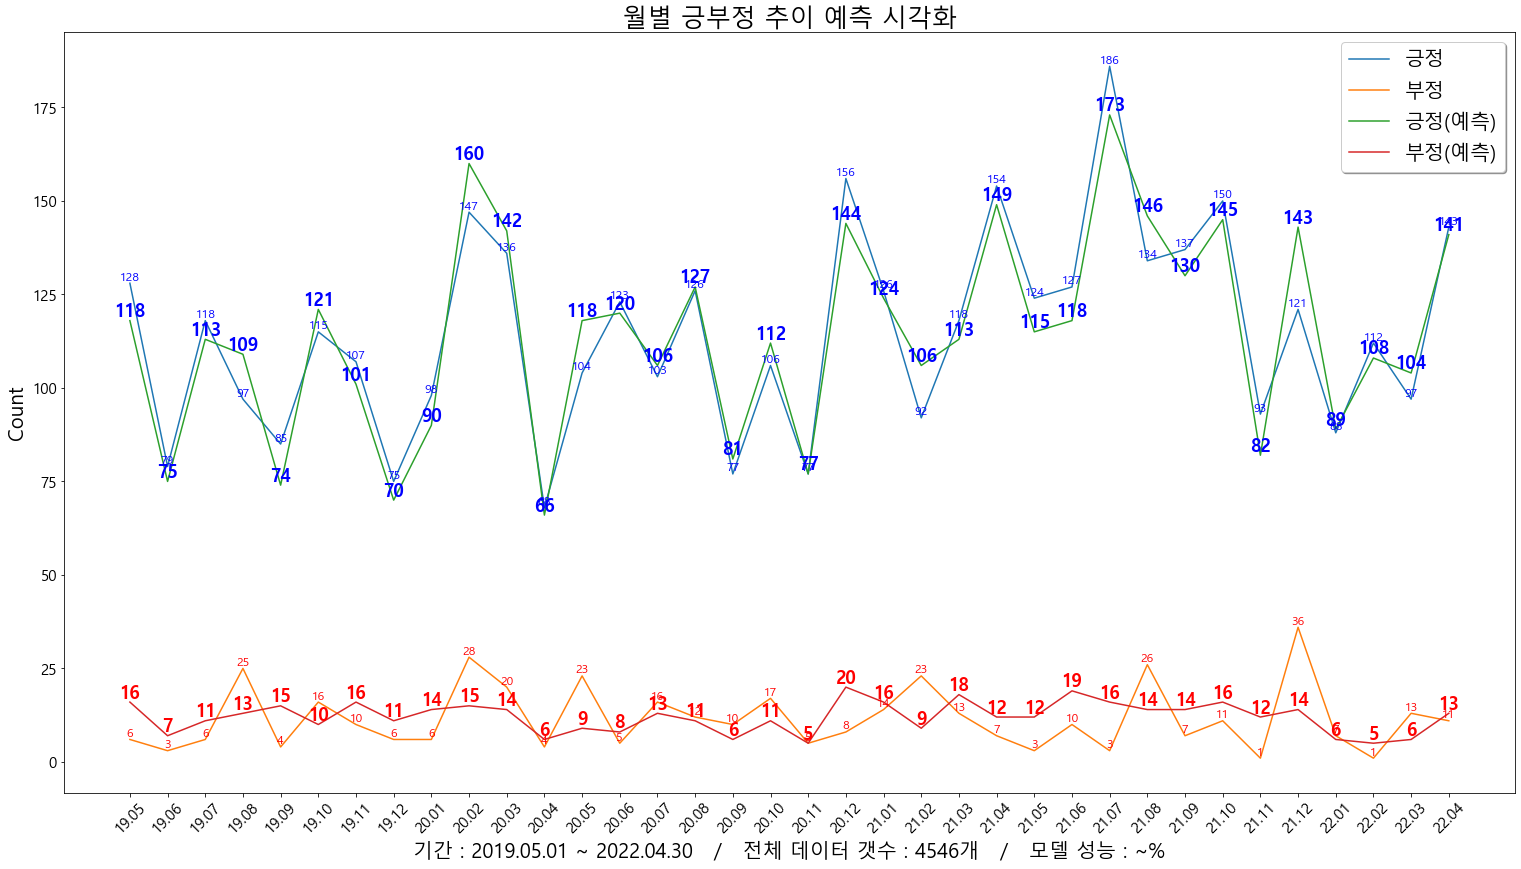

In [97]:
plt.figure(figsize=(26, 14))
for i, v in enumerate(x):
    plt.text(v, pos_raw[i], pos_raw[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 12, color='blue',
             horizontalalignment='center', verticalalignment='bottom')
    
    plt.text(v, neg_raw[i], neg_raw[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 12, color='red', # orange
             horizontalalignment='center', verticalalignment='bottom')
    
    
    plt.text(v, pos_pre[i], pos_pre[i],
             fontsize = 18, color='blue', # green
             horizontalalignment='center', verticalalignment='bottom', fontweight= 'heavy')
    
    plt.text(v, neg_pre[i], neg_pre[i],
             fontsize = 18, color='red',
             horizontalalignment='center', verticalalignment='bottom', fontweight= 'heavy')

plt.plot(date_range, pos_raw, label = '긍정')
plt.plot(date_range, neg_raw, label = '부정')# , color='gray')
plt.plot(date_range, pos_pre, label = '긍정(예측)')
plt.plot(date_range, neg_pre, label = '부정(예측)')

plt.title('월별 긍부정 추이 예측 시각화', size = 25)
plt.xticks(rotation = 45, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('기간 : 2019.05.01 ~ 2022.04.30   /   전체 데이터 갯수 : {}개   /   모델 성능 : ~%'.format(len(df_Visualization)), fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.legend(fontsize = 20, shadow=True, loc = 'best')

# 이미지 저장
plt.savefig('./최종산출물/Binary_line_graph.jpg')
plt.show()

In [99]:
df_Visualization.to_csv('./최종산출물/Final_DataSet(Binary).csv')

## 주간별 그래프 ( 특정 월 선택 )

## [막대 그래프] 전체 데이터에 대한 예측 시각화 (테스트데이터)

In [100]:
df_Visualization_Total = df_Visualization.copy()

In [101]:
def change_idx(labels):
    idx_tmp = list()
    value_tmp = list()
    for i in pd.Series(labels).unique():
        if i == 0:
            idx_tmp.append('부정')
        if i == 1:
            idx_tmp.append('긍정')
        value_tmp.append(list(labels).count(i))
    return value_tmp, idx_tmp

In [102]:
r_value_tmp, r_idx_tmp = change_idx(original_labels)
ori_view = pd.Series(data = r_value_tmp, index = r_idx_tmp)
ori_view.sort_index(ascending=True, inplace=True)

x = list(ori_view.keys())
y = ori_view.values

In [103]:
p_value_tmp, p_idx_tmp = change_idx(predict_labels)
pre_view = pd.Series(data = p_value_tmp, index = p_idx_tmp)
pre_view.sort_index(ascending=True, inplace=True)

w = list(pre_view.keys())
z = pre_view.values

In [104]:
df_Visualization_Total = pd.DataFrame({'raw_label' : 0,
              'predict_label' : 0}, index = ['긍정', '부정'])

In [105]:
idx = 0
for i, j in zip(df_Visualization_Total['raw_label'].index, df_Visualization_Total['predict_label'].index):
    # print(p_value_tmp[p_idx_tmp.index(i)])
    df_Visualization_Total['raw_label'][i] = r_value_tmp[r_idx_tmp.index(i)]
    df_Visualization_Total['predict_label'][j] = p_value_tmp[p_idx_tmp.index(i)]

# df_Visualization_Total['raw_label']['전체'] = len(df_Visualization['raw_label'])
# df_Visualization_Total['predict_label']['전체'] = len(df_Visualization['predict_label'])

In [106]:
df_Visualization_Total

,raw_label,predict_label
긍정,4129,4113
부정,417,433


In [107]:
print('테스트 데이터 셋 예측')
Calculation = list(df_Visualization_Total['predict_label'] / df_Visualization_Total['raw_label'])
row = list(df_Visualization_Total.index)
for idx in range(len(Calculation)):
    print('{} :'.format(row[idx]), end=' ')
    if Calculation[idx] > 1:
        print('{:.2f} %'.format((2 - Calculation[idx]) * 100))
    else:
        print('{:.2f} %'.format(Calculation[idx] * 100))

테스트 데이터 셋 예측
긍정 : 99.61 %
부정 : 96.16 %


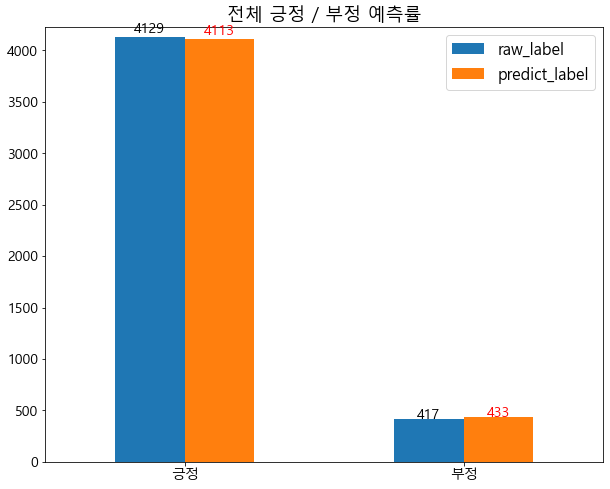

In [110]:
ax = df_Visualization_Total.plot(kind = 'bar', figsize = (10, 8), fontsize=14, rot=0)
graph_value = list(df_Visualization_Total['raw_label']) + list(df_Visualization_Total['predict_label']) + list(['end'])
jump = 0
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    if jump < 2:
        ax.annotate('{}'.format(graph_value.pop(0)), (left+width/2, height*1.01), ha='center', color = 'black', fontsize = 14)
    else:
        ax.annotate('{}'.format(graph_value.pop(0)), (left+width/2, height*1.01), ha='center', color = 'red', fontsize = 14)
    jump += 1

# plt.title("긍정 / 부정 / 중립 예측률", size = 16)
plt.ylim(0, max(max(y), max(z)) + 100)
plt.rc('legend', fontsize=16)  # 범례 폰트 크기
plt.legend()
plt.title('전체 긍정 / 부정 예측률', size = 18)
plt.savefig('savefig_default.jpg')
plt.show()

# 그래프 분석 (EDA)
<br>

**언론사별 / 월별 / 주중별기사 수량 확인**
    
    ▶ 언론사를 각 숫자로 표현 후 EDA 실시 Ex) 1 : 미디어펜, 2 : 아이뉴스24, 3 : 데일리안 ...
    ▶ date : 등록된 기사별 날짜
**아직 제대로 진행 안됨...**

In [ ]:
# 날짜별 데이터 갯수
df_news.groupby('date').count().head(3)

## 월별 기사 갯수
<br>

- 월별로 꺽은선 그래프로 학습된 긍정 / 부정 / 중립 개수 표현하기

**참고사이트 : https://zephyrus1111.tistory.com/9**

In [ ]:
df_news.describe(include='all')

In [ ]:
df_news.head()

In [ ]:
df_news.hist(figsize = (16, 12))
plt.show()

In [ ]:
# 2021년도부터 시작
def next_date_get(x):
    year = 21
    for i in range(len(x)):
        if (x[i] % 12) != 0:
            if x[i] < 10:
                x.insert(i, '{}.0'.format(str(year)) + str(x.pop(i)))
            else:
                x.insert(i, '{}.'.format(str(year)) + str(x.pop(i)))
        else:
            x.insert(i, '{}.'.format(str(year)) + str(x.pop(i))) # 12월까지 카운트
            year += 1 # 다음년도
    return x

# 월별로 정렬이 되어 있으므로 21 ~ 22년도 사이 지정 해주어야 함.
x = next_date_get(df_news['month'].unique().tolist()) 

tmp_a, tmp_b = df_news.groupby('month')['date'].count().tolist()[4:], df_news.groupby('month')['date'].count().tolist()[:4]
y = tmp_a + tmp_b

print('2021.05 ~ :', x) # 월
print('2021.05 ~ :', y) # 값

In [ ]:
plt.figure(figsize = (16, 8))

for i, v in enumerate(x):
    plt.text(v, y[i], y[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 15, 
             color='green',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)

plt.title('월별 뉴스 기사', size = 25)
plt.bar(x, y, width=0.5, color='pink')
plt.xlabel('월별', size = 20, labelpad=20) # x축 제목 설정
plt.ylabel('갯수', size = 20, labelpad=20) #y축 제목 설정, 빨간 글씨
plt.show()

## 언론사별 기사 갯수
- 언론사별 범주형 데이터 --> 수치형으로 변환

In [ ]:
df_news.head(1)

In [ ]:
len(df_news['press'].unique())
df_news['press'].unique()[:5]

In [ ]:
df_news['press'].unique()
x = df_news['press'].value_counts().index.tolist()
y = df_news['press'].value_counts().values.tolist()

In [ ]:
# 기사 갯수가 85 이상인 것만
limit = 0
for idx, value  in enumerate(y):
    if value < 85:
        limit = idx
        break

x = x[:limit]
y = y[:limit]

In [ ]:
df_news['press'].value_counts()[50:]

In [ ]:
plt.figure(figsize = (46, 12))

for i, v in enumerate(x):
    plt.text(v, y[i], y[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 15, 
             color='green',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)

plt.title('언론사별 기사 개수', fontsize = 20)
plt.bar(x, y, width=0.5, color = 'pink')
plt.xticks(rotation = -45)
plt.xlabel('count', fontsize=20)
plt.ylabel('press', fontsize=20)
plt.show()

# 해야할 것들
- 이슈분석지표 워드 클라우드는 이제 단어별 갯수 구한 후 표 그리면 완성
- 감정분석 
<br><br>
- 1. 현재 사용중인 CSV파일이 아닌 1년치 데이터를 스크래핑
<br><br>
- 2. 스크래핑한 데이터의 갯수가 50000개의 데이터라면 / Train_set : 70% Test_set : 30%로 분할 (랜덤모듈이용)<br>
※ 단, Test_set 분할시 2.5%로 12개월분할하면 제일 좋음 ( 매달마다 2.5%의 Test_set를 뽑아와서 총 30%로 만듬.) 1~12월 골고루 뽑아올 수 있음.
<br><br>
- 3. Train_set에 Labeling을 해주어야 함. (긍정 1, 부정 -1, 중립 0)
<br>
※ Labeling 할 때 어떤식으로 정답을 부여할지 생각해야 됨.
<br>
<br>
- 4. 코로나 이전 1년치랑 이후 1년치 데이터 비교
<br>
1. 긍정 부정 단어사전 구축 후 레이블링 작업 진행
